In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime

import csv
from fog.tokenizers import WordTokenizer
import networkx as nx
from ipysigma import Sigma
from pelote import (
    graph_to_edges_dataframe,
    graph_to_nodes_dataframe,
    crop_to_largest_connected_component
)

import re
import math
from tqdm import tqdm
from collections import defaultdict, Counter

In [2]:
stop_list = ["'m", "'re", "'s", 'report', 'person', 'smh', 'it', 'great', 'there', 'days', 'hate', 'look', 'most', 'phone', 'well', 'watch', "'ve", 'm', 'by', 'cause', 'got', 'out', 'too', 'will', 't', 'get', 'video', 'keep', 'care', 'song', 'd', 'mean', 'night', 'was', 'he', 'miss', 'such', 'damn', 'is', 'house', 'a', 'into', 'am', 'been', 'im', 'much', 'one', 'just', 'are', 'really', 'sleep', 'team', 'want', 'work', 'photo', 'gotta', 'its', 'niggas', 'because', 'home', 'already', 'better', 'new', 'now', '3', 'off', 'made', 'over', 'your', 'only', 'tweet', 'week', 'she', 'this', 'didn', 'does', 'god', 'ever', 'dont', 'gonna', "i'", 'after', 'and', 'hard', 'help', 'how', 'in', 'their', 'any', 'him', 'bout', 'never', 'when', 'if', 'take', 'everyone', 'something', 'what', 'talk', "won't", 'they', 's', 'so', 'can', 'show', 'r', 'next', 'tell', 'them', 'guys', 'again', 'than', 'before', 'nigga', 'p', 'thing', 'g', 'w', 'friends', 'best', 'being', 'life', 'said', 'the', 'i', 'l', 'more', 'should', 'play', 'ross', 'someone', 'think', 'on', 'were', 'where', 'far', 'fuck', 'right', 'with', 'school', 'her', 'about', '2012', 'put', 'way', 'fucking', 'twitter', 'back', 'would', 'don', 'or', 'us', 'to', 'e', 'free', 'need', 'thank', 'who', '0', 'hip', 'every', 'gone', 'o', 'bad', 'head', 'at', 'ass', 'ready', 'day', 'll', 'heart', 'his', 'time', "'d", "'ll", 'my', 'f', 'all', 'has', 've', 'other', 'going', 'having', 'shit', 'an', 'go', 'wait', 'did', 'like', 'many', 'follow', 'last', 'morning', 'we', 'away', 'tomorrow', 'you', 'cool', 'no', 'that', 'feel', 'here', 'real', 'had', "don't", 'do', 're', 'live', "can't", 'news', 'lt', 'today', 'love', 'why', 'world', 'check', 'still', 'for', 'know', 'see', 'wish', 'have', 'cant', 'give', 'things', 'two', 'down', 'stop', 'say', 'class', 'done', 'thanks', 'looking', 'up', 'be', 'start', 'find', 'nothing', '1', 'tho', 'though', '2', 'won', 'another', 'hair', 'watching', 'please', 'make', 'then', 'even', 'people', 'let', 'year', 'everything', 'h', 'big', 'girls', 'wanna', 'could', 'from', 'our', 'ain', 'but', 'c', 'doing', 'hop', 'old', 'some', 'of', 'good', 'nice', 'n', 'b', 'as', 'money', 'girl', 'around', 'u', 'face', 'bitch', 'not', 'game', 'always', 'j', 'long', 'lmao', 'same', 'k', 'little', 'getting', 'win', 'these', 'hope', 'amp', 'tonight', 'man', 'come']
NUMBER_PARENTHESIS = re.compile("[0-9\(\)]")

tokenizer = WordTokenizer(lower=True, unidecode=True, drop=["punct", "number"], stoplist=stop_list)

report_class = {}

tokens = Counter()
tokens_per_report = defaultdict(set)
class_per_token = defaultdict(set)
idf = {}

with open("../data/bigfoot.csv", "r") as f:
    reader = csv.DictReader(f)
    for line in tqdm(reader, total=5021):
        report_class[line["number"]] = line["classification"]
        for _, token in tokenizer.tokenize(line["observed"]):
            if not NUMBER_PARENTHESIS.search(token):
                tokens[token] += 1
                class_per_token[token].add(line["classification"])
                tokens_per_report[line["number"]].add(token)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5021/5021 [00:12<00:00, 399.51it/s]


In [3]:
for token in class_per_token.keys(): 
    idf[token] = math.log(5021 / len(class_per_token[token]))

count    27562.000000
mean        25.835498
std        171.010706
min          1.000000
25%          1.000000
50%          2.000000
75%          6.000000
max       9482.000000
dtype: float64

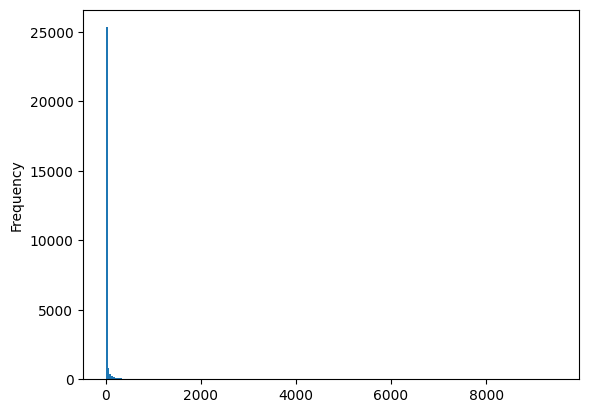

In [4]:
pd.Series(tokens).plot.hist(bins = 250)
pd.Series(tokens).describe()

count    27562.000000
mean         8.216330
std          0.376816
min          7.422772
25%          7.828237
50%          8.521384
75%          8.521384
max          8.521384
dtype: float64

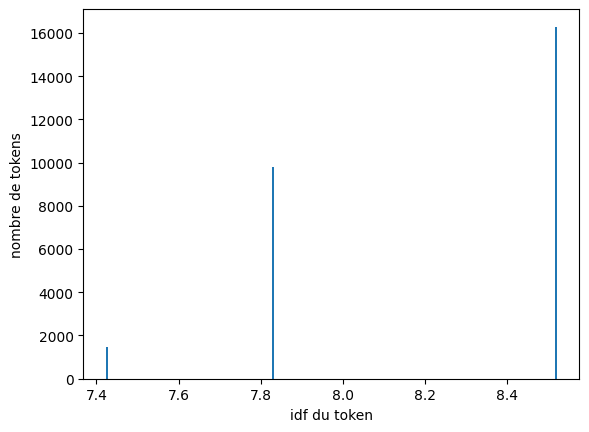

In [5]:
hist = pd.Series(idf).plot.hist(bins = 250)
hist.set_xlabel("idf du token")
hist.set_ylabel("nombre de tokens")
pd.Series(idf).describe()

count    1000.000000
mean        1.789000
std         1.883621
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        30.000000
dtype: float64

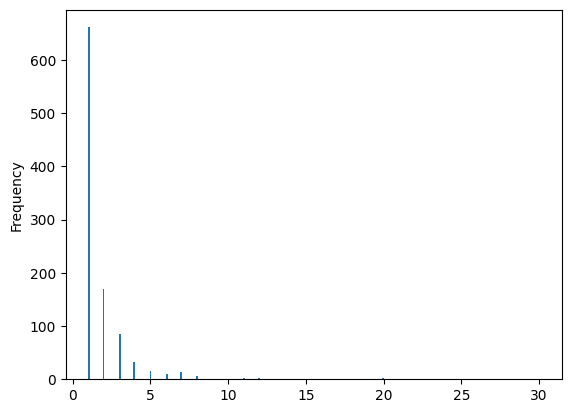

In [6]:
df = {i : j for i, j in tokens.most_common()}
list_idf = [i for i in sorted(idf.items(), key = lambda n : n[1], reverse=True)]
list_idf_1000 = [i[0] for i in list_idf[:1000]]
dict_df_1000 = {k: df[k] for k in list_idf_1000}
dict_idf_1000 = {k: idf[k] for k in list_idf_1000}
pd.Series(dict_df_1000).plot.hist(bins = 250)
pd.Series(dict_df_1000).describe()

count    1.000000e+03
mean     8.521384e+00
std      1.777246e-15
min      8.521384e+00
25%      8.521384e+00
50%      8.521384e+00
75%      8.521384e+00
max      8.521384e+00
dtype: float64

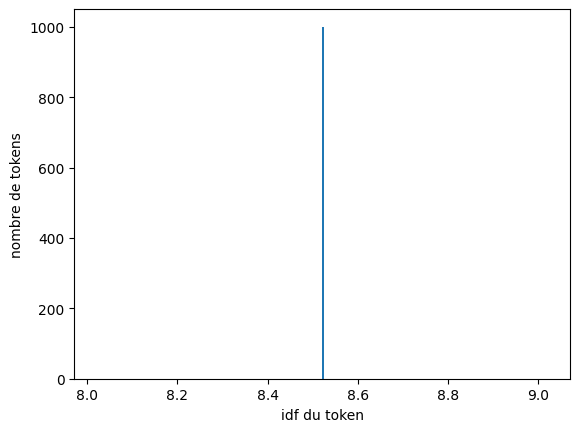

In [7]:
hist = pd.Series(dict_idf_1000).plot.hist(bins = 250)
hist.set_xlabel("idf du token")
hist.set_ylabel("nombre de tokens")
pd.Series(dict_idf_1000).describe()

In [8]:
{key: value for key, value in sorted(dict_df_1000.items(), key=lambda item:item[1], reverse=True)}

{'david': 30,
 'disapeared': 20,
 "it's": 20,
 'monty': 12,
 'groomed': 12,
 'ah': 11,
 'slider': 11,
 'hatchet': 9,
 'un-nerved': 8,
 'outlines': 8,
 'interval': 8,
 'parka': 8,
 'towing': 8,
 'tapes': 8,
 'fainter': 8,
 'whooop': 7,
 'splitting': 7,
 'thirty-five': 7,
 'impacts': 7,
 'drawings': 7,
 'experts': 7,
 'earl': 7,
 'stomps': 7,
 'anderson': 7,
 'gibbon': 7,
 'inspect': 7,
 'distressed': 7,
 'resevoir': 7,
 'fixing': 6,
 'flared': 6,
 'hardest': 6,
 'washes': 6,
 'lizard': 6,
 'rust': 6,
 'auditory': 6,
 'hight': 6,
 'choom': 6,
 'thrilled': 6,
 'res': 5,
 'cared': 5,
 'bushwhack': 5,
 'pretended': 5,
 'divorced': 5,
 'waterloo': 5,
 'cul-de-sac': 5,
 'ranchers': 5,
 'cloudless': 5,
 'off-white': 5,
 'association': 5,
 'unkempt': 5,
 'descriptive': 5,
 'coo': 5,
 'wuh': 5,
 'silky': 4,
 'heh': 4,
 'stole': 4,
 'minot': 4,
 'determining': 4,
 'trellis': 4,
 'staggered': 4,
 'apprehension': 4,
 'inclines': 4,
 'wipers': 4,
 'powerfully': 4,
 'baldy': 4,
 'cane': 4,
 'silty': 

In [9]:
g = nx.Graph()

for report, tokens in tokens_per_report.items():
    g.add_node(
        report,
        classification=report_class[report],
        part="report"
    )
    for token in tokens:
        if token in dict_idf_1000.keys():
            g.add_node(
                token,
                part="token"
            )
            g.add_edge(
                report,
                token
            )
print(g.order(), g.size(), nx.density(g))

crop_to_largest_connected_component(g)

Sigma(
    g,
    node_color="classification"
)

5982 1588 8.876878643510088e-05


Sigma(nx.Graph with 482 nodes and 489 edges)